# 스택킹-lgb 데모
## 라이브러리 import 및 설정

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import lightgbm as lgb
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import warnings
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

## 학습데이터 로드

In [3]:
data_dir = Path('C:\\Users\\USER\\Desktop\\오픈소스SW설계\\단국대\\DataInput\\')
sub_dir = Path('C:\\Users\\USER\\Desktop\\오픈소스SW설계\\단국대\\sub\\')
feature_dir = Path('C:\\Users\\USER\\Desktop\\오픈소스SW설계\\단국대\\DataInput\\')

val_dir = Path('C:\\Users\\USER\\Desktop\\오픈소스SW설계\\단국대\\val')
tst_dir = Path('C:\\Users\\USER\\Desktop\\오픈소스SW설계\\단국대\\tst')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = data_dir / 'sample_submission.csv'

target_col = 'class'
n_fold = 5
n_class = 3
seed = 42

algo_name = 'lgbcv'
feature_name = 'stacking1'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

## Stacking Feature 생성

In [4]:
model_names = ['lrcv_polyfeature', 'rfcv_feature', 'lgbcv_feature']
trn = []
tst = []
feature_names = []
for model in model_names:
    trn.append(np.loadtxt(val_dir / f'{model}.val.csv', delimiter=','))
    tst.append(np.loadtxt(tst_dir / f'{model}.tst.csv', delimiter=','))
    feature_names += [f'{model}_class0', f'{model}_class1', f'{model}_class2']
    
trn = np.hstack(trn)
tst = np.hstack(tst)
feature_names

['lrcv_polyfeature_class0',
 'lrcv_polyfeature_class1',
 'lrcv_polyfeature_class2',
 'rfcv_feature_class0',
 'rfcv_feature_class1',
 'rfcv_feature_class2',
 'lgbcv_feature_class0',
 'lgbcv_feature_class1',
 'lgbcv_feature_class2']

In [5]:

y = pd.read_csv(trn_file, index_col=0, usecols=['id', target_col]).values.flatten()
y.shape

(320000,)

## Stratified K-Fold Cross Validation

In [6]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)


## LightGBM 모델 학습


In [7]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = lgb.LGBMClassifier(objective='multiclass',
                             n_estimators=2000,
                             num_leaves=200,
                             learning_rate=0.01,
                             subsample=.8,
                             subsample_freq=1,
                             colsample_bytree=.8,
                             random_state=seed,
                             n_jobs=-1)
    clf.fit(trn[i_trn], y[i_trn],
            eval_set=[(trn[i_val], y[i_val])],
            eval_metric='multiclass',
            early_stopping_rounds=10)
    
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    p_tst += clf.predict_proba(tst) / n_fold

training model for CV #1
[1]	valid_0's multi_logloss: 0.970045
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 0.954555
[3]	valid_0's multi_logloss: 0.939514
[4]	valid_0's multi_logloss: 0.924918
[5]	valid_0's multi_logloss: 0.910716
[6]	valid_0's multi_logloss: 0.896879
[7]	valid_0's multi_logloss: 0.883414
[8]	valid_0's multi_logloss: 0.870297
[9]	valid_0's multi_logloss: 0.857544
[10]	valid_0's multi_logloss: 0.845059
[11]	valid_0's multi_logloss: 0.832901
[12]	valid_0's multi_logloss: 0.821045
[13]	valid_0's multi_logloss: 0.809471
[14]	valid_0's multi_logloss: 0.798157
[15]	valid_0's multi_logloss: 0.787102
[16]	valid_0's multi_logloss: 0.776319
[17]	valid_0's multi_logloss: 0.765813
[18]	valid_0's multi_logloss: 0.755497
[19]	valid_0's multi_logloss: 0.745402
[20]	valid_0's multi_logloss: 0.735543
[21]	valid_0's multi_logloss: 0.725884
[22]	valid_0's multi_logloss: 0.716445
[23]	valid_0's multi_logloss: 0.707211
[24]	valid_0's multi_loglo

[209]	valid_0's multi_logloss: 0.201676
[210]	valid_0's multi_logloss: 0.201173
[211]	valid_0's multi_logloss: 0.200681
[212]	valid_0's multi_logloss: 0.200177
[213]	valid_0's multi_logloss: 0.199695
[214]	valid_0's multi_logloss: 0.199219
[215]	valid_0's multi_logloss: 0.198738
[216]	valid_0's multi_logloss: 0.198269
[217]	valid_0's multi_logloss: 0.197808
[218]	valid_0's multi_logloss: 0.197372
[219]	valid_0's multi_logloss: 0.196919
[220]	valid_0's multi_logloss: 0.196472
[221]	valid_0's multi_logloss: 0.196042
[222]	valid_0's multi_logloss: 0.195609
[223]	valid_0's multi_logloss: 0.195174
[224]	valid_0's multi_logloss: 0.194763
[225]	valid_0's multi_logloss: 0.194347
[226]	valid_0's multi_logloss: 0.193931
[227]	valid_0's multi_logloss: 0.193543
[228]	valid_0's multi_logloss: 0.193151
[229]	valid_0's multi_logloss: 0.19276
[230]	valid_0's multi_logloss: 0.192371
[231]	valid_0's multi_logloss: 0.19198
[232]	valid_0's multi_logloss: 0.191592
[233]	valid_0's multi_logloss: 0.191236
[2

[417]	valid_0's multi_logloss: 0.164684
[418]	valid_0's multi_logloss: 0.164652
[419]	valid_0's multi_logloss: 0.164611
[420]	valid_0's multi_logloss: 0.164571
[421]	valid_0's multi_logloss: 0.164524
[422]	valid_0's multi_logloss: 0.164485
[423]	valid_0's multi_logloss: 0.16445
[424]	valid_0's multi_logloss: 0.164416
[425]	valid_0's multi_logloss: 0.164376
[426]	valid_0's multi_logloss: 0.164355
[427]	valid_0's multi_logloss: 0.164325
[428]	valid_0's multi_logloss: 0.164283
[429]	valid_0's multi_logloss: 0.164247
[430]	valid_0's multi_logloss: 0.16422
[431]	valid_0's multi_logloss: 0.164174
[432]	valid_0's multi_logloss: 0.164137
[433]	valid_0's multi_logloss: 0.1641
[434]	valid_0's multi_logloss: 0.164059
[435]	valid_0's multi_logloss: 0.164036
[436]	valid_0's multi_logloss: 0.164017
[437]	valid_0's multi_logloss: 0.16399
[438]	valid_0's multi_logloss: 0.163957
[439]	valid_0's multi_logloss: 0.163925
[440]	valid_0's multi_logloss: 0.163896
[441]	valid_0's multi_logloss: 0.163854
[442]

[624]	valid_0's multi_logloss: 0.161487
[625]	valid_0's multi_logloss: 0.161481
[626]	valid_0's multi_logloss: 0.161474
[627]	valid_0's multi_logloss: 0.161477
[628]	valid_0's multi_logloss: 0.161475
[629]	valid_0's multi_logloss: 0.161474
[630]	valid_0's multi_logloss: 0.161469
[631]	valid_0's multi_logloss: 0.161466
[632]	valid_0's multi_logloss: 0.161464
[633]	valid_0's multi_logloss: 0.161466
[634]	valid_0's multi_logloss: 0.161459
[635]	valid_0's multi_logloss: 0.16145
[636]	valid_0's multi_logloss: 0.161451
[637]	valid_0's multi_logloss: 0.161448
[638]	valid_0's multi_logloss: 0.161445
[639]	valid_0's multi_logloss: 0.161439
[640]	valid_0's multi_logloss: 0.161436
[641]	valid_0's multi_logloss: 0.161435
[642]	valid_0's multi_logloss: 0.161431
[643]	valid_0's multi_logloss: 0.161429
[644]	valid_0's multi_logloss: 0.161426
[645]	valid_0's multi_logloss: 0.161421
[646]	valid_0's multi_logloss: 0.161424
[647]	valid_0's multi_logloss: 0.161421
[648]	valid_0's multi_logloss: 0.161418
[

[144]	valid_0's multi_logloss: 0.256514
[145]	valid_0's multi_logloss: 0.255271
[146]	valid_0's multi_logloss: 0.254033
[147]	valid_0's multi_logloss: 0.252817
[148]	valid_0's multi_logloss: 0.251616
[149]	valid_0's multi_logloss: 0.250434
[150]	valid_0's multi_logloss: 0.249273
[151]	valid_0's multi_logloss: 0.248125
[152]	valid_0's multi_logloss: 0.246996
[153]	valid_0's multi_logloss: 0.245896
[154]	valid_0's multi_logloss: 0.244802
[155]	valid_0's multi_logloss: 0.243716
[156]	valid_0's multi_logloss: 0.242654
[157]	valid_0's multi_logloss: 0.241604
[158]	valid_0's multi_logloss: 0.240564
[159]	valid_0's multi_logloss: 0.239545
[160]	valid_0's multi_logloss: 0.238535
[161]	valid_0's multi_logloss: 0.237535
[162]	valid_0's multi_logloss: 0.236549
[163]	valid_0's multi_logloss: 0.235594
[164]	valid_0's multi_logloss: 0.234638
[165]	valid_0's multi_logloss: 0.233699
[166]	valid_0's multi_logloss: 0.232764
[167]	valid_0's multi_logloss: 0.231852
[168]	valid_0's multi_logloss: 0.230952


[351]	valid_0's multi_logloss: 0.168657
[352]	valid_0's multi_logloss: 0.168562
[353]	valid_0's multi_logloss: 0.168475
[354]	valid_0's multi_logloss: 0.168383
[355]	valid_0's multi_logloss: 0.168296
[356]	valid_0's multi_logloss: 0.16821
[357]	valid_0's multi_logloss: 0.168116
[358]	valid_0's multi_logloss: 0.168034
[359]	valid_0's multi_logloss: 0.16795
[360]	valid_0's multi_logloss: 0.16787
[361]	valid_0's multi_logloss: 0.167783
[362]	valid_0's multi_logloss: 0.167703
[363]	valid_0's multi_logloss: 0.167621
[364]	valid_0's multi_logloss: 0.16754
[365]	valid_0's multi_logloss: 0.167464
[366]	valid_0's multi_logloss: 0.167388
[367]	valid_0's multi_logloss: 0.167313
[368]	valid_0's multi_logloss: 0.167239
[369]	valid_0's multi_logloss: 0.167165
[370]	valid_0's multi_logloss: 0.16709
[371]	valid_0's multi_logloss: 0.167017
[372]	valid_0's multi_logloss: 0.166945
[373]	valid_0's multi_logloss: 0.166874
[374]	valid_0's multi_logloss: 0.166801
[375]	valid_0's multi_logloss: 0.166733
[376]

[558]	valid_0's multi_logloss: 0.160997
[559]	valid_0's multi_logloss: 0.160986
[560]	valid_0's multi_logloss: 0.160976
[561]	valid_0's multi_logloss: 0.16097
[562]	valid_0's multi_logloss: 0.160959
[563]	valid_0's multi_logloss: 0.160948
[564]	valid_0's multi_logloss: 0.160936
[565]	valid_0's multi_logloss: 0.160929
[566]	valid_0's multi_logloss: 0.160918
[567]	valid_0's multi_logloss: 0.160907
[568]	valid_0's multi_logloss: 0.160898
[569]	valid_0's multi_logloss: 0.160889
[570]	valid_0's multi_logloss: 0.160877
[571]	valid_0's multi_logloss: 0.16087
[572]	valid_0's multi_logloss: 0.160863
[573]	valid_0's multi_logloss: 0.160856
[574]	valid_0's multi_logloss: 0.160847
[575]	valid_0's multi_logloss: 0.160835
[576]	valid_0's multi_logloss: 0.160824
[577]	valid_0's multi_logloss: 0.160815
[578]	valid_0's multi_logloss: 0.160807
[579]	valid_0's multi_logloss: 0.160795
[580]	valid_0's multi_logloss: 0.160783
[581]	valid_0's multi_logloss: 0.160775
[582]	valid_0's multi_logloss: 0.160767
[5

[32]	valid_0's multi_logloss: 0.633291
[33]	valid_0's multi_logloss: 0.625772
[34]	valid_0's multi_logloss: 0.618396
[35]	valid_0's multi_logloss: 0.611166
[36]	valid_0's multi_logloss: 0.604069
[37]	valid_0's multi_logloss: 0.597114
[38]	valid_0's multi_logloss: 0.590288
[39]	valid_0's multi_logloss: 0.583587
[40]	valid_0's multi_logloss: 0.577013
[41]	valid_0's multi_logloss: 0.570566
[42]	valid_0's multi_logloss: 0.564232
[43]	valid_0's multi_logloss: 0.558016
[44]	valid_0's multi_logloss: 0.551912
[45]	valid_0's multi_logloss: 0.545912
[46]	valid_0's multi_logloss: 0.540023
[47]	valid_0's multi_logloss: 0.534245
[48]	valid_0's multi_logloss: 0.528568
[49]	valid_0's multi_logloss: 0.522991
[50]	valid_0's multi_logloss: 0.517516
[51]	valid_0's multi_logloss: 0.512134
[52]	valid_0's multi_logloss: 0.506843
[53]	valid_0's multi_logloss: 0.50165
[54]	valid_0's multi_logloss: 0.496553
[55]	valid_0's multi_logloss: 0.49154
[56]	valid_0's multi_logloss: 0.486616
[57]	valid_0's multi_loglos

[239]	valid_0's multi_logloss: 0.190478
[240]	valid_0's multi_logloss: 0.190135
[241]	valid_0's multi_logloss: 0.189791
[242]	valid_0's multi_logloss: 0.189458
[243]	valid_0's multi_logloss: 0.189124
[244]	valid_0's multi_logloss: 0.188794
[245]	valid_0's multi_logloss: 0.188471
[246]	valid_0's multi_logloss: 0.188148
[247]	valid_0's multi_logloss: 0.187839
[248]	valid_0's multi_logloss: 0.187526
[249]	valid_0's multi_logloss: 0.187225
[250]	valid_0's multi_logloss: 0.18692
[251]	valid_0's multi_logloss: 0.186618
[252]	valid_0's multi_logloss: 0.186327
[253]	valid_0's multi_logloss: 0.186029
[254]	valid_0's multi_logloss: 0.185738
[255]	valid_0's multi_logloss: 0.18545
[256]	valid_0's multi_logloss: 0.185164
[257]	valid_0's multi_logloss: 0.184884
[258]	valid_0's multi_logloss: 0.184606
[259]	valid_0's multi_logloss: 0.184335
[260]	valid_0's multi_logloss: 0.184065
[261]	valid_0's multi_logloss: 0.1838
[262]	valid_0's multi_logloss: 0.183537
[263]	valid_0's multi_logloss: 0.183281
[264

[447]	valid_0's multi_logloss: 0.163951
[448]	valid_0's multi_logloss: 0.163919
[449]	valid_0's multi_logloss: 0.163884
[450]	valid_0's multi_logloss: 0.163853
[451]	valid_0's multi_logloss: 0.163825
[452]	valid_0's multi_logloss: 0.163794
[453]	valid_0's multi_logloss: 0.16376
[454]	valid_0's multi_logloss: 0.163727
[455]	valid_0's multi_logloss: 0.163697
[456]	valid_0's multi_logloss: 0.163661
[457]	valid_0's multi_logloss: 0.163628
[458]	valid_0's multi_logloss: 0.163598
[459]	valid_0's multi_logloss: 0.16357
[460]	valid_0's multi_logloss: 0.163544
[461]	valid_0's multi_logloss: 0.163517
[462]	valid_0's multi_logloss: 0.163489
[463]	valid_0's multi_logloss: 0.16346
[464]	valid_0's multi_logloss: 0.163435
[465]	valid_0's multi_logloss: 0.163409
[466]	valid_0's multi_logloss: 0.16338
[467]	valid_0's multi_logloss: 0.163351
[468]	valid_0's multi_logloss: 0.163321
[469]	valid_0's multi_logloss: 0.163289
[470]	valid_0's multi_logloss: 0.163264
[471]	valid_0's multi_logloss: 0.163238
[472

[656]	valid_0's multi_logloss: 0.161203
[657]	valid_0's multi_logloss: 0.1612
[658]	valid_0's multi_logloss: 0.1612
[659]	valid_0's multi_logloss: 0.161196
[660]	valid_0's multi_logloss: 0.161192
[661]	valid_0's multi_logloss: 0.16119
[662]	valid_0's multi_logloss: 0.16119
[663]	valid_0's multi_logloss: 0.16119
[664]	valid_0's multi_logloss: 0.161186
[665]	valid_0's multi_logloss: 0.161185
[666]	valid_0's multi_logloss: 0.161184
[667]	valid_0's multi_logloss: 0.161181
[668]	valid_0's multi_logloss: 0.161178
[669]	valid_0's multi_logloss: 0.161175
[670]	valid_0's multi_logloss: 0.161175
[671]	valid_0's multi_logloss: 0.161172
[672]	valid_0's multi_logloss: 0.16117
[673]	valid_0's multi_logloss: 0.161165
[674]	valid_0's multi_logloss: 0.161165
[675]	valid_0's multi_logloss: 0.161161
[676]	valid_0's multi_logloss: 0.161159
[677]	valid_0's multi_logloss: 0.161159
[678]	valid_0's multi_logloss: 0.161159
[679]	valid_0's multi_logloss: 0.161162
[680]	valid_0's multi_logloss: 0.16116
[681]	val

[151]	valid_0's multi_logloss: 0.24825
[152]	valid_0's multi_logloss: 0.247126
[153]	valid_0's multi_logloss: 0.246018
[154]	valid_0's multi_logloss: 0.244924
[155]	valid_0's multi_logloss: 0.24385
[156]	valid_0's multi_logloss: 0.24279
[157]	valid_0's multi_logloss: 0.241742
[158]	valid_0's multi_logloss: 0.24071
[159]	valid_0's multi_logloss: 0.239691
[160]	valid_0's multi_logloss: 0.238687
[161]	valid_0's multi_logloss: 0.2377
[162]	valid_0's multi_logloss: 0.236724
[163]	valid_0's multi_logloss: 0.235764
[164]	valid_0's multi_logloss: 0.234813
[165]	valid_0's multi_logloss: 0.233877
[166]	valid_0's multi_logloss: 0.232959
[167]	valid_0's multi_logloss: 0.232047
[168]	valid_0's multi_logloss: 0.231154
[169]	valid_0's multi_logloss: 0.23027
[170]	valid_0's multi_logloss: 0.229397
[171]	valid_0's multi_logloss: 0.228534
[172]	valid_0's multi_logloss: 0.227688
[173]	valid_0's multi_logloss: 0.226849
[174]	valid_0's multi_logloss: 0.226022
[175]	valid_0's multi_logloss: 0.225206
[176]	v

[357]	valid_0's multi_logloss: 0.169189
[358]	valid_0's multi_logloss: 0.169105
[359]	valid_0's multi_logloss: 0.169028
[360]	valid_0's multi_logloss: 0.168945
[361]	valid_0's multi_logloss: 0.168867
[362]	valid_0's multi_logloss: 0.168789
[363]	valid_0's multi_logloss: 0.168713
[364]	valid_0's multi_logloss: 0.168632
[365]	valid_0's multi_logloss: 0.168561
[366]	valid_0's multi_logloss: 0.168484
[367]	valid_0's multi_logloss: 0.168404
[368]	valid_0's multi_logloss: 0.168333
[369]	valid_0's multi_logloss: 0.168259
[370]	valid_0's multi_logloss: 0.168188
[371]	valid_0's multi_logloss: 0.168118
[372]	valid_0's multi_logloss: 0.168042
[373]	valid_0's multi_logloss: 0.167973
[374]	valid_0's multi_logloss: 0.167903
[375]	valid_0's multi_logloss: 0.167834
[376]	valid_0's multi_logloss: 0.167768
[377]	valid_0's multi_logloss: 0.167701
[378]	valid_0's multi_logloss: 0.167638
[379]	valid_0's multi_logloss: 0.167569
[380]	valid_0's multi_logloss: 0.167503
[381]	valid_0's multi_logloss: 0.167437


[566]	valid_0's multi_logloss: 0.162398
[567]	valid_0's multi_logloss: 0.162392
[568]	valid_0's multi_logloss: 0.162389
[569]	valid_0's multi_logloss: 0.162385
[570]	valid_0's multi_logloss: 0.162381
[571]	valid_0's multi_logloss: 0.162374
[572]	valid_0's multi_logloss: 0.162372
[573]	valid_0's multi_logloss: 0.162363
[574]	valid_0's multi_logloss: 0.162357
[575]	valid_0's multi_logloss: 0.162349
[576]	valid_0's multi_logloss: 0.162341
[577]	valid_0's multi_logloss: 0.162334
[578]	valid_0's multi_logloss: 0.162325
[579]	valid_0's multi_logloss: 0.16232
[580]	valid_0's multi_logloss: 0.162314
[581]	valid_0's multi_logloss: 0.16231
[582]	valid_0's multi_logloss: 0.162302
[583]	valid_0's multi_logloss: 0.162299
[584]	valid_0's multi_logloss: 0.162293
[585]	valid_0's multi_logloss: 0.162284
[586]	valid_0's multi_logloss: 0.162282
[587]	valid_0's multi_logloss: 0.162277
[588]	valid_0's multi_logloss: 0.162273
[589]	valid_0's multi_logloss: 0.162269
[590]	valid_0's multi_logloss: 0.162266
[5

[83]	valid_0's multi_logloss: 0.379646
[84]	valid_0's multi_logloss: 0.376531
[85]	valid_0's multi_logloss: 0.373476
[86]	valid_0's multi_logloss: 0.370462
[87]	valid_0's multi_logloss: 0.367494
[88]	valid_0's multi_logloss: 0.364573
[89]	valid_0's multi_logloss: 0.3617
[90]	valid_0's multi_logloss: 0.358887
[91]	valid_0's multi_logloss: 0.356103
[92]	valid_0's multi_logloss: 0.353358
[93]	valid_0's multi_logloss: 0.350653
[94]	valid_0's multi_logloss: 0.347992
[95]	valid_0's multi_logloss: 0.345375
[96]	valid_0's multi_logloss: 0.34279
[97]	valid_0's multi_logloss: 0.340256
[98]	valid_0's multi_logloss: 0.337754
[99]	valid_0's multi_logloss: 0.335289
[100]	valid_0's multi_logloss: 0.332862
[101]	valid_0's multi_logloss: 0.330473
[102]	valid_0's multi_logloss: 0.328138
[103]	valid_0's multi_logloss: 0.325823
[104]	valid_0's multi_logloss: 0.323541
[105]	valid_0's multi_logloss: 0.321293
[106]	valid_0's multi_logloss: 0.319107
[107]	valid_0's multi_logloss: 0.316925
[108]	valid_0's mult

[290]	valid_0's multi_logloss: 0.176025
[291]	valid_0's multi_logloss: 0.175842
[292]	valid_0's multi_logloss: 0.175665
[293]	valid_0's multi_logloss: 0.17549
[294]	valid_0's multi_logloss: 0.175315
[295]	valid_0's multi_logloss: 0.175141
[296]	valid_0's multi_logloss: 0.174972
[297]	valid_0's multi_logloss: 0.174801
[298]	valid_0's multi_logloss: 0.174634
[299]	valid_0's multi_logloss: 0.174469
[300]	valid_0's multi_logloss: 0.174303
[301]	valid_0's multi_logloss: 0.174141
[302]	valid_0's multi_logloss: 0.17399
[303]	valid_0's multi_logloss: 0.173841
[304]	valid_0's multi_logloss: 0.173691
[305]	valid_0's multi_logloss: 0.173539
[306]	valid_0's multi_logloss: 0.173391
[307]	valid_0's multi_logloss: 0.173242
[308]	valid_0's multi_logloss: 0.173091
[309]	valid_0's multi_logloss: 0.172945
[310]	valid_0's multi_logloss: 0.172799
[311]	valid_0's multi_logloss: 0.172653
[312]	valid_0's multi_logloss: 0.172518
[313]	valid_0's multi_logloss: 0.172377
[314]	valid_0's multi_logloss: 0.172242
[3

[495]	valid_0's multi_logloss: 0.161691
[496]	valid_0's multi_logloss: 0.161671
[497]	valid_0's multi_logloss: 0.161653
[498]	valid_0's multi_logloss: 0.161631
[499]	valid_0's multi_logloss: 0.161609
[500]	valid_0's multi_logloss: 0.161591
[501]	valid_0's multi_logloss: 0.161578
[502]	valid_0's multi_logloss: 0.161558
[503]	valid_0's multi_logloss: 0.161541
[504]	valid_0's multi_logloss: 0.161524
[505]	valid_0's multi_logloss: 0.161508
[506]	valid_0's multi_logloss: 0.161493
[507]	valid_0's multi_logloss: 0.161477
[508]	valid_0's multi_logloss: 0.16146
[509]	valid_0's multi_logloss: 0.161444
[510]	valid_0's multi_logloss: 0.161426
[511]	valid_0's multi_logloss: 0.161415
[512]	valid_0's multi_logloss: 0.161402
[513]	valid_0's multi_logloss: 0.161384
[514]	valid_0's multi_logloss: 0.161367
[515]	valid_0's multi_logloss: 0.161349
[516]	valid_0's multi_logloss: 0.161329
[517]	valid_0's multi_logloss: 0.161308
[518]	valid_0's multi_logloss: 0.161296
[519]	valid_0's multi_logloss: 0.161284
[

[701]	valid_0's multi_logloss: 0.160264
[702]	valid_0's multi_logloss: 0.160268
[703]	valid_0's multi_logloss: 0.160268
[704]	valid_0's multi_logloss: 0.160264
[705]	valid_0's multi_logloss: 0.160263
[706]	valid_0's multi_logloss: 0.160267
[707]	valid_0's multi_logloss: 0.160262
[708]	valid_0's multi_logloss: 0.160263
[709]	valid_0's multi_logloss: 0.160261
[710]	valid_0's multi_logloss: 0.160258
[711]	valid_0's multi_logloss: 0.160257
[712]	valid_0's multi_logloss: 0.160258
[713]	valid_0's multi_logloss: 0.16026
[714]	valid_0's multi_logloss: 0.160261
[715]	valid_0's multi_logloss: 0.16026
[716]	valid_0's multi_logloss: 0.160263
[717]	valid_0's multi_logloss: 0.160267
[718]	valid_0's multi_logloss: 0.160268
[719]	valid_0's multi_logloss: 0.16027
[720]	valid_0's multi_logloss: 0.160266
[721]	valid_0's multi_logloss: 0.16027
Early stopping, best iteration is:
[711]	valid_0's multi_logloss: 0.160257


In [8]:
print(f'{accuracy_score(y, np.argmax(p_val, axis=1)) * 100:.4f}%')

93.3109%


In [9]:
print(p_val.shape, p_tst.shape)


(320000, 3) (80000, 3)


In [10]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

# 피처 중요도 시각화


In [21]:
clf.coef_.shape

AttributeError: 'LGBMClassifier' object has no attribute 'coef_'

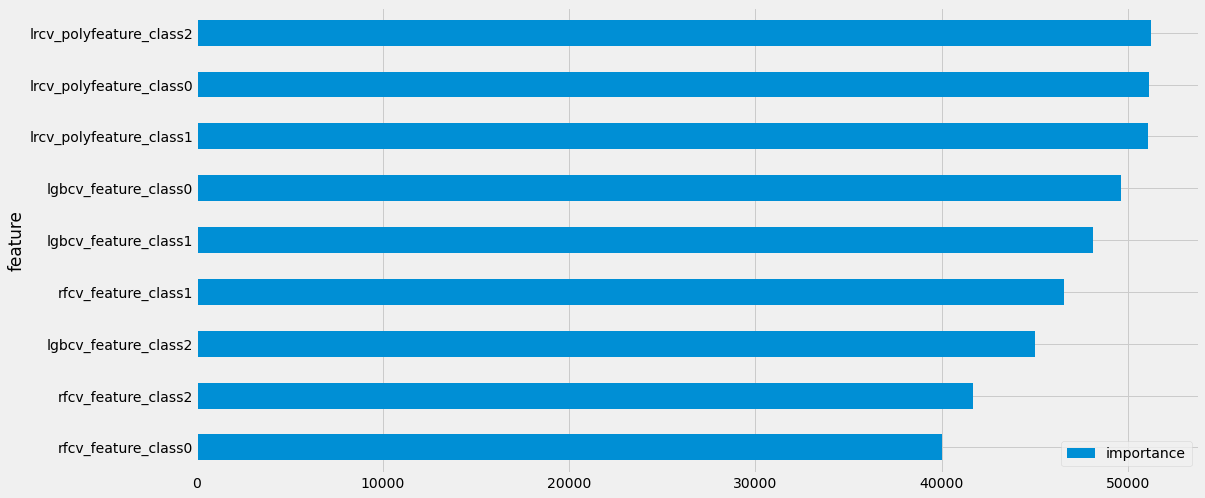

In [11]:

imp = pd.DataFrame({'feature': feature_names, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

## 제출 파일 생성¶


In [12]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
#sub.head()
sub[target_col] = np.argmax(p_tst, axis=1)
    

(80000, 1)


In [13]:
sub[target_col].value_counts()


2    40795
0    29987
1     9218
Name: class, dtype: int64

In [14]:
sub.to_csv(sub_file)
